### Import and connect

In [1]:
from sqlalchemy import create_engine
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
DATABASE = 'group_8_2024'
USER = 'group_8_2024' 
PASSWORD = '8Yy148rzOyOm'
HOST = 'dbcourse.cs.aalto.fi'

connection = psycopg2.connect (
    database = DATABASE ,
    user = USER ,
    password = PASSWORD ,
    host = HOST ,
    port = '5432'
)
connection.autocommit = True
cursor = connection.cursor()
DIALECT = 'postgresql+psycopg2://'
db_uri = "%s:%s@%s/%s" % (USER, PASSWORD, HOST, DATABASE)
engine = create_engine(DIALECT + db_uri)
psql_conn = engine.connect()

In [3]:
psql_conn.rollback()

## PART 1

### Visualize the number of volunteers by city.

In [4]:
sql_volunteers_by_city = """
SELECT available.city_id, c."name", available_volunteer, applied_volunteer
FROM
	(SELECT city_id, COUNT(DISTINCT vr.volunteer_id) as available_volunteer
	FROM volunteer_range vr
	GROUP BY city_id) AS available
JOIN
	(SELECT rl.city_id, COUNT(DISTINCT va.volunteer_id) as applied_volunteer
	FROM request_location rl, request r, volunteer_application va
	WHERE rl.request_id = r.id AND r.id = va.request_id AND va.is_valid 
	GROUP BY rl.city_id) AS applied
ON available.city_id = applied.city_id
JOIN city c ON available.city_id = c.id
"""
volunteers_by_city_df = pd.read_sql_query(sql_volunteers_by_city, psql_conn)
volunteers_by_city_df

,city_id,name,available_volunteer,applied_volunteer
0,704,Rusko,63,182
1,72,Hailuoto,61,177
2,426,Liperi,55,169
3,886,Ulvila,59,177
4,834,Tammela,56,178
5,687,Rautavaara,55,181
6,504,Myrskylä,58,176
7,783,Säkylä,49,172


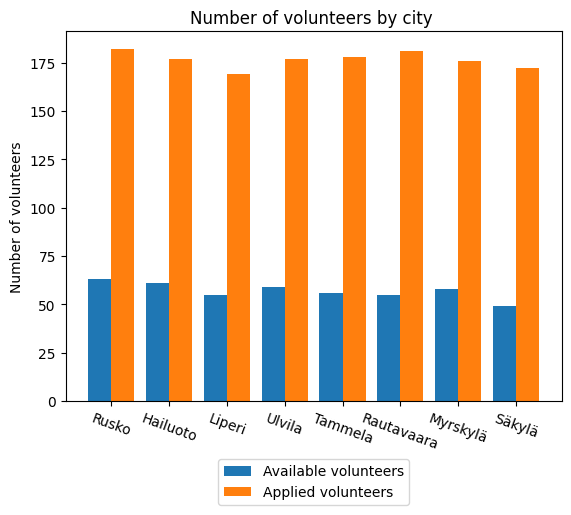

In [5]:
num_of_city_range = np.arange(len(volunteers_by_city_df)) 
  
plt.bar(num_of_city_range - 0.2, volunteers_by_city_df['available_volunteer'], 0.4, label = 'Available volunteers') 
plt.bar(num_of_city_range + 0.2, volunteers_by_city_df['applied_volunteer'], 0.4, label = 'Applied volunteers') 

plt.xticks(num_of_city_range, volunteers_by_city_df['name'], rotation=-20) 
plt.ylabel('Number of volunteers') 
plt.title('Number of volunteers by city ') 
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3)) 
plt.show() 

### Cities with the most and the least volunteers.

As we can see from the chart and table:

- Two cities with most applied volunteers: Rusko and Rautavaara

- Two cities with most available volunteers: Rusko and Hailuoto

- Two cities with least applied volunteers: Ulvila and Säkylä

- Two cities with least available volunteers: Säkylä and Liperi

## PART 2

### Scoring system to calculate the matching percentage of volunteers.

##### Criterias:
- Skill score (worth 70%): 
    - **(skill_value+1)** * matched * 100/ sum(**(skill_value+1)**), with matched having value of 0 or 1
- Range score (worth 20%): This is the percentage of request's location that is in the volunteer's range

- Travel readiness score (worth 5%): The greater the travel-readiness (tr), the smaller the score. The formula will be:
    - max(1 - tr/1200, 0)
- Interest score (worth 5%): If the interests of the request and volunteer match, he/she will have 100% points. Otherwise, he/she will have 0 point.

In [6]:
# interest score
sql_calculate_skill_score = """
CREATE OR REPLACE VIEW skill_score AS
	WITH total_value AS (
			SELECT request_id, SUM(rs.value+1) AS sum_value
			FROM request_skill rs
			GROUP BY rs.request_id)
	SELECT tv.request_id, va.volunteer_id, COALESCE(100*SUM(value+1)::NUMERIC/MAX(sum_value)::NUMERIC,0) AS score
	FROM volunteer_application va
	LEFT JOIN total_value tv ON va.request_id = tv.request_id AND va.is_valid
	LEFT JOIN skill_assignment sa ON sa.volunteer_id = va.volunteer_id
	LEFT JOIN request_skill rs ON rs.skill_name = sa.skill_name AND rs.request_id = va.request_id 
	GROUP BY tv.request_id, va.volunteer_id;
    """
cursor.execute(sql_calculate_skill_score)

In [7]:
# range score
sql_calculate_range_score = """
CREATE OR REPLACE VIEW range_score AS
	WITH location_count AS(
		SELECT request_id, COUNT(*) as sum
		FROM request_location rl 
		GROUP BY rl.request_id 
	)
	SELECT va.request_id, va.volunteer_id, 100*COUNT(*)/AVG(lc.sum) AS score
	FROM volunteer_application va
	LEFT JOIN request_location rl ON rl.request_id = va.request_id AND is_valid 
	LEFT JOIN volunteer_range vr ON vr.volunteer_id = va.volunteer_id AND vr.city_id = rl.city_id
	LEFT JOIN location_count lc ON lc.request_id = va.request_id 
	GROUP BY va.request_id, va.volunteer_id;
    """
cursor.execute(sql_calculate_range_score)

In [8]:
# travel reainess score
sql_calculate_travel_readiness_score = """
CREATE OR REPLACE VIEW travel_readiness_score AS
	SELECT va.request_id, va.volunteer_id, GREATEST(0, 1-travel_readiness::NUMERIC/1200) AS score
	FROM volunteer_application va
	LEFT JOIN volunteer v ON v.id = va.volunteer_id AND va.is_valid;
"""
cursor.execute(sql_calculate_travel_readiness_score)

In [9]:
# interest score
sql_calculate_interest_score = """
CREATE OR REPLACE VIEW interest_assignment_corrected AS 
	SELECT 
	    CASE 
	        WHEN ia.interest_name = 'WorkInATeam' THEN 'WorkInTeam' 
	        ELSE ia.interest_name 
	    END AS interest_name,
	    ia.volunteer_id
	FROM 
	    interest_assignment ia;

CREATE OR REPLACE VIEW interest_corrected AS
	SELECT
		CASE 
	        WHEN i."name" = 'WorkInATeam' THEN 'WorkInTeam' 
	        ELSE i."name"
	    END AS interest_name 
	FROM 
	    interest i;

CREATE OR REPLACE VIEW interest_score AS
	WITH request_interest AS(
		SELECT r.id, ic.interest_name
		FROM request r, interest_corrected ic
		WHERE ic.interest_name ILIKE SUBSTRING(REPLACE(r.title, ' ', '') FROM 1 FOR POSITION('needed' IN REPLACE(r.title, ' ', '')) - 1)
		)
	SELECT va.request_id, va.volunteer_id, COALESCE(iac.interest_name IS NOT NULL :: INT * 100, 0) AS score
	FROM volunteer_application va
	LEFT JOIN request_interest ri ON va.request_id = ri.id
	LEFT JOIN interest_assignment_corrected iac ON iac.interest_name = ri.interest_name AND iac.volunteer_id = va.volunteer_id;
    """
cursor.execute(sql_calculate_interest_score)

In [10]:
# final score
sql_volunteer_score = """
SELECT rs.request_id, rs.volunteer_id, isc.score*0.05 + rs.score*0.2 + trs.score*0.05 + ss.score*0.7 AS final_score
FROM range_score rs
LEFT JOIN skill_score ss ON rs.request_id = ss.request_id AND rs.volunteer_id = ss.volunteer_id
LEFT JOIN interest_score isc ON rs.request_id = isc.request_id AND rs.volunteer_id = isc.volunteer_id
LEFT JOIN travel_readiness_score trs ON rs.request_id = trs.request_id AND rs.volunteer_id = trs.volunteer_id   
ORDER BY request_id, final_score DESC;
"""

volunteer_score_df = pd.read_sql_query(sql_volunteer_score, psql_conn)
top_five_volunteer = volunteer_score_df.groupby('request_id').apply(lambda x: x.nlargest(5, 'final_score')).droplevel(-2)
top_five_volunteer.head(20)


,request_id,volunteer_id,final_score
0,1,230283-963X,77.294394
1,1,211074-9401,44.120617
2,1,011074-9149,39.121826
3,1,211099-910H,39.090909
4,1,250681-919H,32.771189
8,2,270794-9576,71.784089
9,2,220782-910B,59.593551
10,2,190697-999B,58.488969
11,2,200569-926L,47.436888
12,2,101003A9918,46.337514


## PART C

### The number of valid volunteer applications and the number of valid requests in each month.

In [11]:
sql_request_application_by_month = """
SELECT m AS month, COUNT(DISTINCT r.id) AS request, COUNT(DISTINCT va.id) AS application
FROM generate_series(1, 12) m
LEFT JOIN volunteer_application va ON m = EXTRACT(MONTH FROM va.modified) AND is_valid
LEFT JOIN request r ON m = EXTRACT(MONTH FROM r.end_date) OR m = EXTRACT(MONTH FROM r.start_date)
GROUP BY m
"""

request_application_by_month_df = pd.read_sql_query(sql_request_application_by_month, psql_conn)
request_application_by_month_df['difference'] = request_application_by_month_df['application'] - request_application_by_month_df['request']
request_application_by_month_df

,month,request,application,difference
0,1,25,152,127
1,2,21,147,126
2,3,29,127,98
3,4,25,183,158
4,5,27,217,190
5,6,45,229,184
6,7,40,307,267
7,8,45,238,193
8,9,44,264,220
9,10,31,202,171


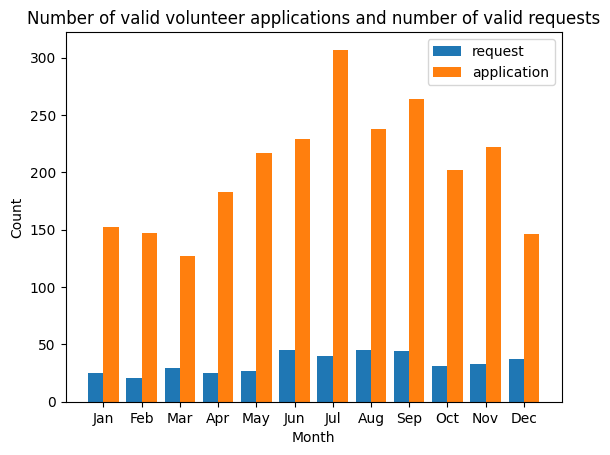

In [12]:
month_list = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
# 12 means 12 month
month_range = np.arange(12)
plt.bar(month_range - 0.2, request_application_by_month_df['request'], 0.4, label = 'request') 
plt.bar(month_range + 0.2, request_application_by_month_df['application'], 0.4, label = 'application') 
plt.xticks(month_range, month_list) 
plt.ylabel('Count') 
plt.xlabel('Month')
plt.legend()
plt.title('Number of valid volunteer applications and number of valid requests') 
plt.show()

### Months with the most and least volunteers and requests, and the difference between the requests and volunteers for each month.

As we can see from the plot, July has the most volunteer applications, with 307 applications. June and August have the most volunteer requests, with 45 requests each.

The difference between the number of requests and applications ranges from 98 in March to 267 in July, with applications consistently exceeding requests.

### Trend and correlation

In [13]:
print(f"The correlation between the month and the number of applications from January to July: {request_application_by_month_df['month'].head(7).corr(request_application_by_month_df['application'].head(7))}")
print(f"The correlation between the month and the number of applications from July to December: {request_application_by_month_df['month'].tail(5).corr(request_application_by_month_df['application'].tail(5))}")
print(f"The correlation between the month and the number of requests: {request_application_by_month_df['month'].corr(request_application_by_month_df['request'])}")




The correlation between the month and the number of applications from January to July: 0.8939412382878384
The correlation between the month and the number of applications from July to December: -0.8037057534208327
The correlation between the month and the number of requests: 0.5887239015046365


Request Trend: The number of requests increases significantly around mid-year (April to June), peaking around June and August, then declining towards the end of the year and reaching bottom in February.

Application Trend: The number of applications starts to rise in March, reaching a pronouced peak in July, then decline and hit bottom around March.

The correlation between the month and the number of requests is moderate (0.59). This indicates that the number of requests also tends to change according to the month, but not very strongly. On the other hand, the correlation between the month and the number of applications is stronger.There is a strong positive correlation from January to July (0.89), and a weaker but strong negative correlation in the rest of the year (-0.80).


## PART D

### Calculate the total average duration (in hours) of requests associated with each city.

In [14]:
sql_total_volunteer_hour = """
WITH request_location_count AS(
	SELECT request_id, COUNT(*) as count
	FROM request_location rl 
	GROUP BY request_id)
SELECT 
	c.id, 
	c."name", 
	SUM((EXTRACT(DAY FROM r.end_date-r.start_date) * 24.0 + 
	EXTRACT(HOUR FROM r.end_date-r.start_date) + 
	EXTRACT(MINUTE FROM r.end_date-r.start_date) / 60.0 + 
	EXTRACT(SECOND FROM r.end_date-r.start_date) / 3600.0) / count) AS total_hours
FROM city c 
LEFT JOIN request_location rl ON c.id = rl.city_id 
LEFT JOIN request r ON r.id = rl.request_id 
LEFT JOIN request_location_count rlc ON rlc.request_id = rl.request_id 
GROUP BY c.id, c."name"
"""

total_volunteer_hour_df = pd.read_sql_query(sql_total_volunteer_hour, psql_conn)
total_volunteer_hour_df


,id,name,total_hours
0,426,Liperi,1223.775000
1,783,Säkylä,1248.925000
2,504,Myrskylä,2427.045833
3,704,Rusko,3711.633333
4,72,Hailuoto,2235.033333
5,687,Rautavaara,3086.400000
6,886,Ulvila,1424.208333
7,834,Tammela,1947.229167


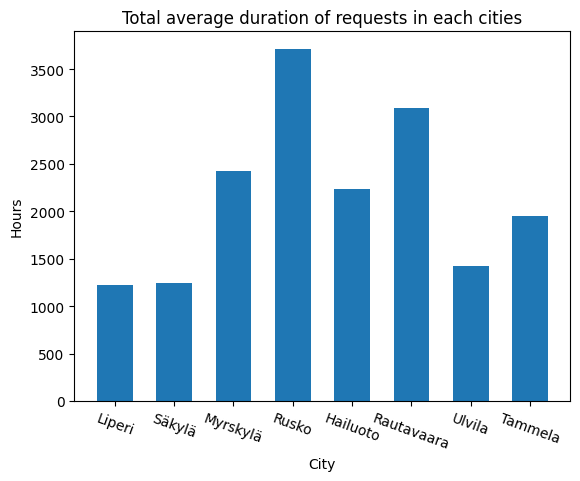

In [15]:
plt.bar(x=total_volunteer_hour_df['name'],height=total_volunteer_hour_df['total_hours'], width=0.6)
plt.xlabel('City')
plt.ylabel('Hours')
plt.xticks(rotation=-20)
plt.title('Total average duration of requests in each cities')
plt.show()

Among the cities, Rusko has the highest average duration, somewhere above 3500 hours. Rautavaara follows with approximately 3000 hours. Myrskylä and Hailuoto are next, both surpassing 2000 hours. In the next place is Tammela with around 2000 hours and Ulvila with around 1500 hours. Finally, Liperi and Säkylä share the last place with around 1250 hours.